In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
from dataclasses import dataclass
from itertools import product
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from rotary_kiln.reactors import make_single_reactor
from rotary_kiln.units import nm3h_to_kg_s

In [5]:
X_OXID = "N2: 0.78, O2: 0.21, Ar: 0.01"
X_FUEL = "CH4: 1.00"

In [6]:
@dataclass
class TwoChamberConfig:
    """ Configuration class for two chamber combustor. """
    mech: str = "gri30.yaml"
    T0: float = 1000.0
    T1: float = 300.0
    T2: float = 300.0
    frac: float= 0.1
    v1: float = 0.1
    v2: float = 1.0
    x_fuel_0: str = X_FUEL
    x_oxid_1: str = X_OXID
    x_oxid_2: str = X_OXID
    qdot_fuel_0: float = 347.0
    qdot_oxid_1: float = 775.0
    qdot_oxid_2: float = 4920.0

In [7]:
def two_chambers_burner(c):
    """ Compute output products of a setup consisting of two reactors. """
    fuel_0 = ct.Solution(c.mech)
    oxid_1 = ct.Solution(c.mech)
    oxid_2 = ct.Solution(c.mech)

    fuel_0.TPX = c.T0, ct.one_atm, c.x_fuel_0
    oxid_1.TPX = c.T1, ct.one_atm, c.x_oxid_1
    oxid_2.TPX = c.T2, ct.one_atm, c.x_oxid_2

    mdot_fuel_0 = nm3h_to_kg_s(c.qdot_fuel_0, m=fuel_0.mean_molecular_weight)
    mdot_oxid_1 = nm3h_to_kg_s(c.qdot_oxid_1, m=oxid_1.mean_molecular_weight)
    mdot_oxid_2 = nm3h_to_kg_s(c.qdot_oxid_2, m=oxid_2.mean_molecular_weight)

    mdot = mdot_fuel_0 + mdot_oxid_1 + mdot_oxid_2

    reactor_1 = make_single_reactor(c.mech, T=c.T0, V=c.v1)
    reactor_2 = make_single_reactor(c.mech, T=c.T0, V=c.v2)

    res_vent_0 = ct.Reservoir(oxid_1)
    res_oxid_1 = ct.Reservoir(oxid_1)
    res_oxid_2 = ct.Reservoir(oxid_2)
    res_fuel_0 = ct.Reservoir(fuel_0)

    mdot_1 = mdot_oxid_1 + c.frac * mdot_oxid_2
    mdot_2 = (1.0 - c.frac) * mdot_oxid_2

    ct.MassFlowController(res_fuel_0, reactor_1, mdot=mdot_fuel_0)
    ct.MassFlowController(res_oxid_1, reactor_1, mdot=mdot_1)
    ct.MassFlowController(res_oxid_2, reactor_2, mdot=mdot_2)

    ct.Valve(reactor_1, reactor_2, K=1.0)
    ct.Valve(reactor_2, res_vent_0, K=1.0)

    sim = ct.ReactorNet([reactor_1, reactor_2])
    sim.advance_to_steady_state()

    return mdot, reactor_2.thermo

In [8]:
def explore_parameters(x_rng, y_rng, x_name, y_name, confm, n_states=10):
    """ Cross-evaluate effect of parameters over model outputs. """
    df = pd.DataFrame(columns=[x_name, y_name, "Tf", "Xf"])
    x_vals = np.linspace(*x_rng, n_states)
    y_vals = np.linspace(*y_rng, n_states)

    for k, (x, y)  in enumerate(product(x_vals, y_vals)):
        _, thermo = two_chambers_burner(confm({x_name: x, y_name: y}))
        idx_ch4 = thermo.species_index("CH4")
        df.loc[k] = [x, y, thermo.T, thermo.X[idx_ch4]]

    Tf = df.pivot(index=x_name, columns=y_name, values="Tf")
    Xf = df.pivot(index=x_name, columns=y_name, values="Xf")
    return Tf, Xf

In [9]:
def plot_parameters_roles(Tf, x_rng, y_rng, x_label, y_label):
    """ Display effect of parameters over flame temperature. """
    plt.close("all")
    fig, ax = plt.subplots(figsize=(8, 8))
    mappable = ax.imshow(Tf, cmap="inferno", extent=[*x_rng, *y_rng])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_aspect("auto")
    cb = fig.colorbar(mappable, fraction=0.046, pad=0.04)
    cb.set_label("Flame temperature [K]")
    fig.tight_layout()

In [10]:
def sensitivity_v1_v2(confm):
    """ Parametric sensitivity analysis. """
    x_name = "v1"
    y_name = "v2"
    x_rng = (0.1, 0.5)
    y_rng = (0.1, 1.5)
    x_label = "Volume 1 [m³]"
    y_label = "Volume 2 [m³]"
    Tf, _ = explore_parameters(x_rng, y_rng, x_name, y_name, confm, n_states=10)
    plot_parameters_roles(Tf, x_rng, y_rng, x_label, y_label)


def sensitivity_T0_v1(confm):
    """ Parametric sensitivity analysis. """
    x_name = "T0"
    y_name = "v1"
    x_rng = (1000.0, 1400.0)
    y_rng = (0.5, 3.0)
    x_label = "Initial temperature [K]"
    y_label = "Volume 1 [m³]"
    Tf, _ = explore_parameters(x_rng, y_rng, x_name, y_name, confm, n_states=10)
    plot_parameters_roles(Tf, x_rng, y_rng, x_label, y_label)


def sensitivity_T0_frac(confm):
    """ Parametric sensitivity analysis. """
    x_name = "T0"
    y_name = "frac"
    x_rng = (1000.0, 1400.0)
    y_rng = (0.0, 1.0)
    x_label = "Initial temperature [K]"
    y_label = "Dilution fraction [-]"
    Tf, _ = explore_parameters(x_rng, y_rng, x_name, y_name, confm, n_states=10)
    plot_parameters_roles(Tf, x_rng, y_rng, x_label, y_label)

In [11]:
def confm_gri30(pars):
    """ Create a configuration based on Gri-Mech 3.0. """
    return TwoChamberConfig(mech="gri30.yaml", **pars)

def confm_2s(pars):
    """ Create a configuration based on 2S_CH4_BFER. """
    return TwoChamberConfig(mech="2S_CH4_BFER.yaml", **pars)

CPU times: total: 12.7 s
Wall time: 12.7 s


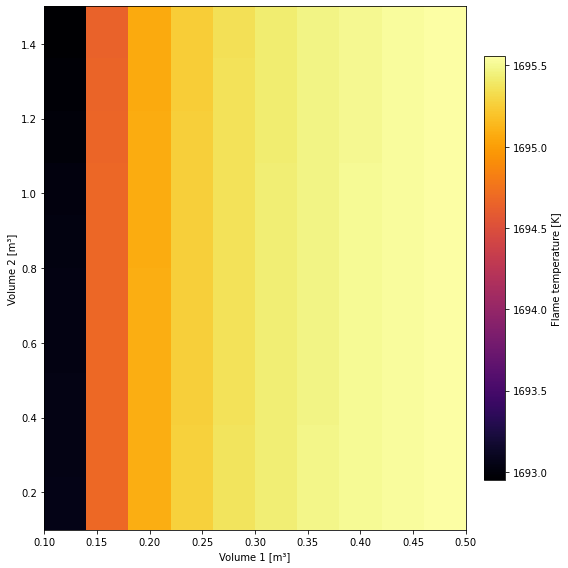

In [12]:
%%time
sensitivity_v1_v2(confm_2s)

CPU times: total: 13.8 s
Wall time: 13.8 s


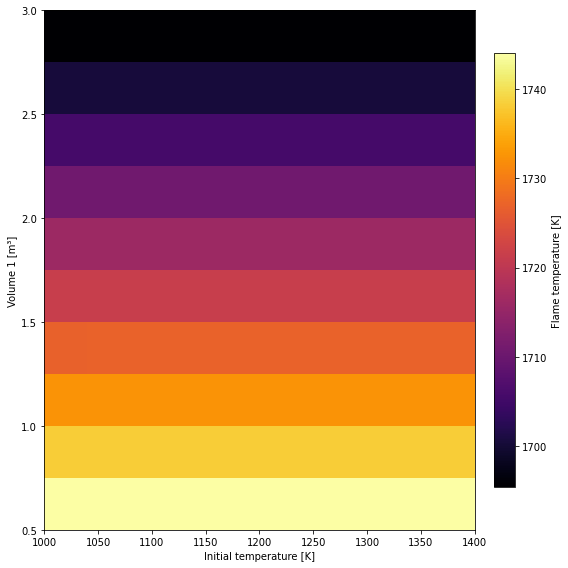

In [13]:
%%time
sensitivity_T0_v1(confm_2s)

CPU times: total: 9.53 s
Wall time: 9.56 s


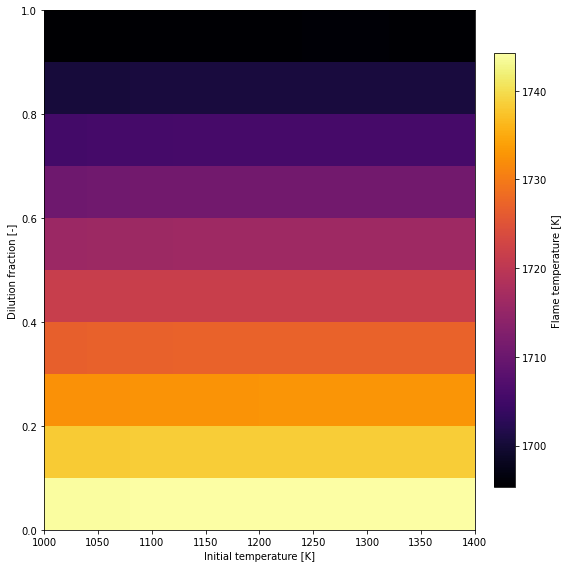

In [14]:
%%time
sensitivity_T0_frac(confm_2s)

In [15]:
def equilibrate_hp(mech, c, T0=1000.0):
    """ Compute """
    gas = ct.Solution(mech)

    gas.TPX = 300, ct.one_atm, X_FUEL
    mdot_fuel_0 = nm3h_to_kg_s(c.qdot_fuel_0, m=gas.mean_molecular_weight)

    gas.TPX = 300, ct.one_atm, X_OXID
    mdot_oxid_1 = nm3h_to_kg_s(c.qdot_oxid_1, m=gas.mean_molecular_weight)
    mdot_oxid_2 = nm3h_to_kg_s(c.qdot_oxid_2, m=gas.mean_molecular_weight)

    m = gas.molecular_weights[[
        gas.species_index("CH4"),
        gas.species_index("O2"),
        gas.species_index("N2")
    ]]

    fto_mx = mdot_fuel_0 / (mdot_oxid_1 + mdot_oxid_2)
    fto_st = m[0] / (m[1] + 3.76 * m[2])
    phi = fto_mx / fto_st

    print(mdot_fuel_0, mdot_oxid_1, mdot_oxid_2)
    
    gas.set_equivalence_ratio(phi, X_FUEL, X_OXID, basis="mole")

    gas.TP = c.T0, ct.one_atm
    gas.equilibrate("HP")
    print(gas.report())

In [16]:
c = TwoChamberConfig()
c.T0 = 300.0

equilibrate_hp("2S_CH4_BFER.yaml", c)
equilibrate_hp("gri30.yaml", c)

0.0653997910780118 0.2637615585591661 1.674460474982061

  CH4_BFER:

       temperature   1043.2 K
          pressure   1.0133e+05 Pa
           density   0.33398 kg/m^3
  mean mol. weight   28.589 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy            -74876       -2.1407e+06  J
   internal energy       -3.7827e+05       -1.0814e+07  J
           entropy            8377.3         2.395e+05  J/K
    Gibbs function       -8.8142e+06       -2.5199e+08  J
 heat capacity c_p            1200.8             34331  J/K
 heat capacity c_v            910.01             26017  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.16223           0.14495           -28.614
               H2O          0.037096          0.058871           -55.711
          